In [2]:
import itertools
import cv2
import os
import time
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

In [3]:
folders = glob('lung_image_sets' + '/*')

In [6]:
path = 'lung_image_sets'
classes = os.listdir(path)
print(classes)
IMAGE_FILES = glob('lung_image_sets' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

['lung_aca', 'lung_n', 'lung_scc']
Images Count:  15000


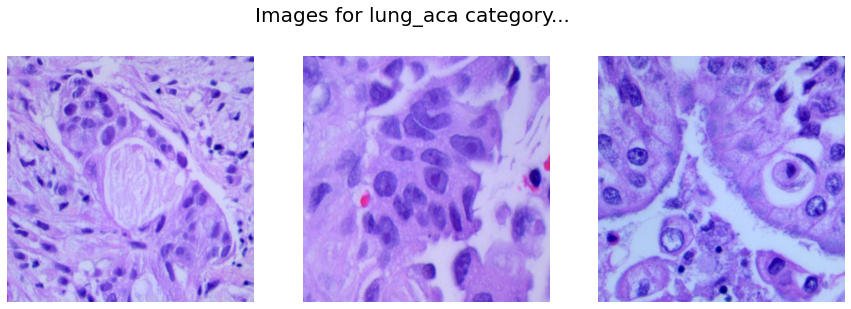

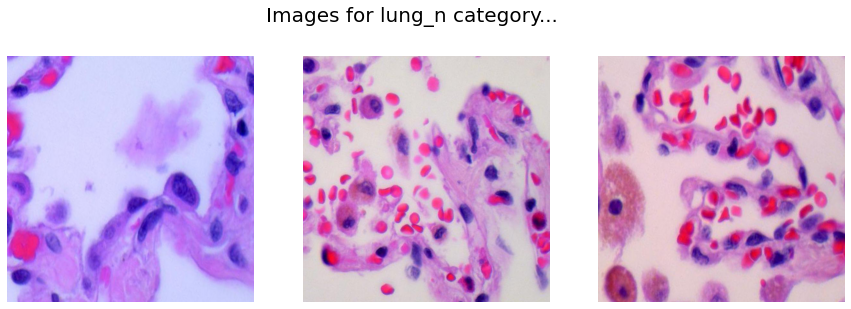

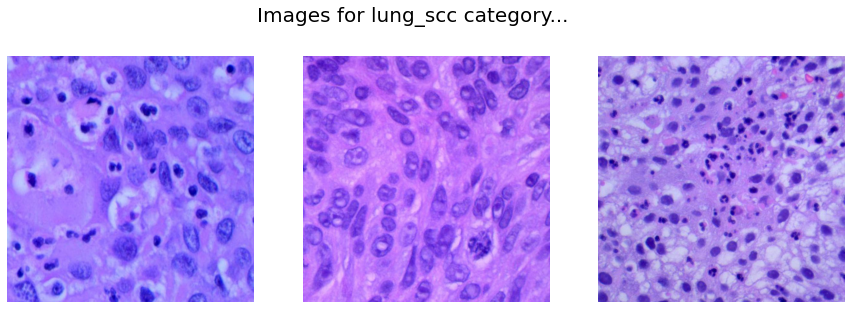

In [7]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category...', fontsize = 20)
    
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [8]:
data_dir = './lung_image_sets'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 16

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 224

train_ds = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

Found 12000 images belonging to 3 classes.


In [9]:
validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 3000 images belonging to 3 classes.


In [10]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)

In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePoolin

                                                                                                  
 block2a_activation (Activation  (None, 56, 56, 192)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 192)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2a_se_reshape[0][0]']     
          

                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 56, 56, 288)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 56, 56, 48)   13824       ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block2e_project_conv (Conv2D)  (None, 56, 56, 48)   13824       ['block2e_se_excite[0][0]']      
                                                                                                  
 block2e_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2e_drop (Dropout)         (None, 56, 56, 48)   0           ['block2e_project_bn[0][0]']     
                                                                                                  
 block2e_add (Add)              (None, 56, 56, 48)   0           ['block2e_drop[0][0]',           
                                                                  'block2d_add[0][0]']            
          

                                                                                                  
 block2g_drop (Dropout)         (None, 56, 56, 48)   0           ['block2g_project_bn[0][0]']     
                                                                                                  
 block2g_add (Add)              (None, 56, 56, 48)   0           ['block2g_drop[0][0]',           
                                                                  'block2f_add[0][0]']            
                                                                                                  
 block3a_expand_conv (Conv2D)   (None, 56, 56, 288)  13824       ['block2g_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 56, 56, 288)  1152       ['block3a_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 28, 28, 480)  1920       ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_expand_activation (Act  (None, 28, 28, 480)  0          ['block3c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3c_dwconv (DepthwiseConv2  (None, 28, 28, 480)  12000      ['block3c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3c_b

 ivation)                                                                                         
                                                                                                  
 block3e_dwconv (DepthwiseConv2  (None, 28, 28, 480)  12000      ['block3e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3e_bn (BatchNormalization  (None, 28, 28, 480)  1920       ['block3e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3e_activation (Activation  (None, 28, 28, 480)  0          ['block3e_bn[0][0]']             
 )                                                                                                
          

 block3g_bn (BatchNormalization  (None, 28, 28, 480)  1920       ['block3g_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3g_activation (Activation  (None, 28, 28, 480)  0          ['block3g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3g_se_squeeze (GlobalAver  (None, 480)         0           ['block3g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3g_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3g_se_squeeze[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
          

                                                                                                  
 block4d_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4d_se_reduce[0][0]']      
                                                                                                  
 block4d_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4d_activation[0][0]',     
                                                                  'block4d_se_expand[0][0]']      
                                                                                                  
 block4d_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4d_se_excite[0][0]']      
                                                                                                  
 block4d_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4d_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block4f_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_drop (Dropout)         (None, 14, 14, 160)  0           ['block4f_project_bn[0][0]']     
                                                                                                  
 block4f_add (Add)              (None, 14, 14, 160)  0           ['block4f_drop[0][0]',           
                                                                  'block4e_add[0][0]']            
          

                                                                                                  
 block4h_drop (Dropout)         (None, 14, 14, 160)  0           ['block4h_project_bn[0][0]']     
                                                                                                  
 block4h_add (Add)              (None, 14, 14, 160)  0           ['block4h_drop[0][0]',           
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 14, 14, 960)  153600      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 960)  153600      ['block4j_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 14, 14, 960)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5a_expand_activation[0][0]
 D)       

                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 1344  33600      ['block5c_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5c_activation (Activation  (None, 14, 14, 1344  0          ['block5c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5c_s

                                                                                                  
 block5e_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5e_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5e_activation (Activation  (None, 14, 14, 1344  0          ['block5e_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 1344)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_s

                                                                                                  
 block5g_activation (Activation  (None, 14, 14, 1344  0          ['block5g_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1344)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5g_se_reshape[0][0]']     
          

                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 1344)        0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5i_se_reshape[0][0]']     
                                                                                                  
 block5i_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5i_se_reduce[0][0]']      
                                                                                                  
 block5i_s

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1344)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 384)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_a

 block6e_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 384)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 384)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6e_add[0][0]']            
                                                                                                  
 block6f_e

 block6g_add (Add)              (None, 7, 7, 384)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6j_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6j_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6j_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6j_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6j_dwconv[0][0]']         
 )        

                                                                                                  
 block6l_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6l_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6l_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6l_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 2304)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_s

 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 7, 7, 2304)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 2304)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_s

 block7c_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7c_se_reshape[0][0]']     
                                                                                                  
 block7c_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7c_se_reduce[0][0]']      
                                                                                                  
 block7c_se_excite (Multiply)   (None, 7, 7, 3840)   0           ['block7c_activation[0][0]',     
                                                                  'block7c_se_expand[0][0]']      
                                                                                                  
 block7c_project_conv (Conv2D)  (None, 7, 7, 640)    2457600     ['block7c_se_excite[0][0]']      
                                                                                                  
 block7c_project_bn (BatchNorma  (None, 7, 7, 640)   2560        ['block7c_project_conv[0][0]']   
 lization)

In [13]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='NN-mnist.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_ds,
    validation_data=validation,
    epochs=5,
    callbacks=[early_stopping])

Epoch 1/5
750/750 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9302

ResourceExhaustedError: Graph execution error:

Detected at node 'model/stem_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\nishantjairath\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\nishantjairath\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\nishantjairath\Anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\nishantjairath\Anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\nishantjairath\Anaconda3\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-15-8e82e5a75cf3>", line 3, in <module>
      history = model.fit(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1606, in fit
      val_logs = self.evaluate(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/stem_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[16,112,112,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/stem_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_54335]